# MATWM + Curiosity-Driven Intrinsic Rewards

## 目的

非中央集権型MARL（Multi-Agent Reinforcement Learning）において、
**好奇心駆動の内発的報酬**を導入し、探索効率と協調学習を改善する。

- **環境**: PettingZoo `simple_tag_v3`（3 追手 vs 1 逃走者）
- **ベースモデル**: MATWM (Multi-Agent Transformer World Model)
- **新規提案**: 計算型好奇心 + LLM 意味的好奇心の二層構造

---

## なぜ好奇心が必要か（非中央集権型MARLにおけるモチベーション）

### 1. 部分観測性と信用割当の困難
各エージェントは局所的な観測しか得られず、環境報酬の変動が自分の行動の結果なのか、
他エージェントの行動の結果なのか区別できない。
**Social Curiosity** は「TeammatePredictor の予測が外れた」ことを検出し、
未知の他エージェント行動パターンの存在を間接的に示唆する。

### 2. 探索の局所化
中央集権型では全体の状態空間を見渡して探索を誘導できるが、
非中央集権型では「全員が同じ局所最適に陥る」相関探索問題が発生する。
好奇心は各エージェントに個別の探索動機を与え、探索行動を多様化させる。

### 3. 報酬の希薄性
追手チームが獲物を捕まえるまで有意な報酬が得られない。
好奇心報酬は環境構造に基づく密な報酬シグナルを提供する。

---

## 好奇心の二層構造

| 層 | 手法 | 頻度 | 内容 |
|---|---|---|---|
| **計算型好奇心** | World Model 予測誤差 | 毎ステップ | Dynamics / Reward / Social Curiosity |
| **意味的好奇心** | LLM 評価 | エピソード終了時 | 戦略的新規性の判断、探索/活用フェーズの制御 |

### Social Curiosity ★（核心）
TeammatePredictor が予測した他エージェントの行動と実際の行動の乖離。
これは非中央集権型MARLに**固有**の好奇心形態であり、
単一エージェントRLの好奇心（RND, ICM等）には存在しない概念である。

## 1. セットアップ

In [4]:
# 必要パッケージのインストール
%pip install pygame
%pip install --no-deps pettingzoo
%pip install numpy gymnasium supersuit
%pip install torchinfo requests

import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

# デバイス設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'  GPU: {torch.cuda.get_device_name(0)}')
    print(f'  VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

Device: cuda
  GPU: NVIDIA A100-SXM4-40GB
  VRAM: 42.5 GB


In [5]:
# 環境の作成と仕様確認
from pettingzoo.mpe import simple_tag_v3

def make_env(max_cycles=25, seed=None):
    env = simple_tag_v3.parallel_env(
        num_good=1,
        num_adversaries=3,
        num_obstacles=2,
        max_cycles=max_cycles,
        continuous_actions=False,
        render_mode=None,
    )
    if seed is not None:
        env.reset(seed=seed)
    return env

env = make_env(seed=0)
obs, info = env.reset(seed=0)

print('=== Environment Specifications ===')
print('Agents:', env.agents)
print('\nObservation shapes:')
for agent in env.agents:
    print(f'  {agent}: {obs[agent].shape}')
print('\nAction spaces:')
for agent in env.agents:
    print(f'  {agent}: {env.action_space(agent)}')
env.close()

=== Environment Specifications ===
Agents: ['adversary_0', 'adversary_1', 'adversary_2', 'agent_0']

Observation shapes:
  adversary_0: (16,)
  adversary_1: (16,)
  adversary_2: (16,)
  agent_0: (14,)

Action spaces:
  adversary_0: Discrete(5)
  adversary_1: Discrete(5)
  adversary_2: Discrete(5)
  agent_0: Discrete(5)


## 2. MATWM 実装の読み込み

In [6]:
from matwm_implementation import MATWMConfig, pad_observation
from matwm_utils import (
    initialize_matwm_weights, init_weights,
    save_full_checkpoint, load_full_checkpoint,
    plot_training_progress,
    inspect_matwm_architecture,
    print_gpu_info, setup_matwm_training
)
from matwm_agent import MATWMAgent

# 設定
config = MATWMConfig(
    total_steps=2000,   # 論文再現時は50000
    warmup_steps=200,
    log_interval=50,
    save_interval=1000,
)

print('=== MATWM Configuration ===')
print(f'  Total steps: {config.total_steps}')
print(f'  Warmup steps: {config.warmup_steps}')
print(f'  Latent dim: {config.latent_dim}x{config.num_classes}')
print(f'  Imagination horizon: {config.imagination_horizon}')
print(f'  Max observation dim: {config.max_obs_dim} (zero-padding)')

MATWM implementation loaded successfully!
Key components:
  - Encoder/Decoder (Categorical VAE)
  - DynamicsModel (Transformer-based)
  - TeammatePredictor ★ Social World Model Core ★
  - Actor/Critic Networks
  - PrioritizedReplayBuffer
MATWMAgent class loaded successfully!
=== MATWM Configuration ===
  Total steps: 200
  Warmup steps: 20
  Latent dim: 32x32
  Imagination horizon: 12
  Max observation dim: 16 (zero-padding)


In [7]:
# 観測パディングのテスト
print('=== Observation Padding Test ===')
test_obs_14 = np.random.randn(14)
test_obs_16 = np.random.randn(16)

padded_14 = pad_observation(test_obs_14, config.max_obs_dim)
padded_16 = pad_observation(test_obs_16, config.max_obs_dim)

print(f'14 dim -> {padded_14.shape}, last 2 = {padded_14[-2:]} (should be 0)')
print(f'16 dim -> {padded_16.shape}, unchanged = {np.allclose(test_obs_16, padded_16)}')
print('✓ Zero-padding OK')

=== Observation Padding Test ===
14 dim -> (16,), last 2 = [0. 0.] (should be 0)
16 dim -> (16,), unchanged = True
✓ Zero-padding OK


In [8]:
# GPU環境とアーキテクチャ確認
gpu_info = print_gpu_info()
setup_info = setup_matwm_training(config, device)

# 共有World Modelの作成と検証
shared_world_model, shared_wm_optimizer = MATWMAgent.create_shared_world_model(config, device)
dummy_agent = MATWMAgent(config, 'adversary_0', 0, device, shared_world_model=shared_world_model)

print('\n=== Weight Initialization ===')
initialize_matwm_weights(shared_world_model, dummy_agent.actor, dummy_agent.critic)

inspect_matwm_architecture(shared_world_model, dummy_agent.actor, dummy_agent.critic, config, device)


GPU ENVIRONMENT INFORMATION

CUDA Available: True
PyTorch Version: 2.9.0+cu126
CUDA Version: 12.6

[Current Device]
  Device ID: 0
  GPU Name: NVIDIA A100-SXM4-40GB

[Available GPUs: 1]
----------------------------------------------------------------------
  GPU 0: NVIDIA A100-SXM4-40GB
    - Compute Capability: 8.0
    - Total Memory: 42.47 GB
    - Memory Allocated: 0.00 GB
    - Memory Reserved: 0.00 GB

[GPU Type Identification]
----------------------------------------------------------------------
  GPU 0: NVIDIA A100 (High-end Datacenter GPU)



MATWM TRAINING SETUP

GPU ENVIRONMENT INFORMATION

CUDA Available: True
PyTorch Version: 2.9.0+cu126
CUDA Version: 12.6

[Current Device]
  Device ID: 0
  GPU Name: NVIDIA A100-SXM4-40GB

[Available GPUs: 1]
----------------------------------------------------------------------
  GPU 0: NVIDIA A100-SXM4-40GB
    - Compute Capability: 8.0
    - Total Memory: 42.47 GB
    - Memory Allocated: 0.00 GB
    - Memory Reserved: 0.00 GB

[GPU Typ

## 3. 好奇心モジュールの設定

好奇心の3成分:
- **Dynamics Curiosity** (重み 1.0): World Modelの状態予測誤差
- **Reward Curiosity** (重み 0.5): 報酬予測の誤差
- **Social Curiosity** (重み 2.0 ★): TeammatePredictor の行動予測誤差

Social Curiosity を重くする理由:
非中央集権型では他エージェントの行動が最大の不確実性源であり、
この不確実性を積極的に探索することが協調学習の加速に直結する。

In [9]:
from curiosity_reward import CuriosityConfig, create_curiosity_managers

# ★ OpenRouter API キーを設定してください
OPENROUTER_API_KEY = os.environ.get('OPENROUTER_API_KEY', 'sk-.........')
MODEL_NAME = 'google/gemma-3-4b-it:free'
LOG_DIR = 'llm_logs'

curiosity_config = CuriosityConfig(
    # 計算型好奇心の重み
    dynamics_curiosity_weight=1.0,
    reward_curiosity_weight=0.5,
    social_curiosity_weight=2.0,     # ★ 社会的好奇心を重視

    # 減衰方法
    curiosity_decay_method='adaptive',  # WMの学習進捗に連動
    curiosity_initial_weight=1.0,
    curiosity_min_weight=0.1,

    # LLM意味的好奇心
    use_llm_curiosity=(OPENROUTER_API_KEY != 'YOUR_API_KEY_HERE'),
    llm_api_key=OPENROUTER_API_KEY,
    llm_model=MODEL_NAME,
    llm_eval_every_n_episodes=1,
    semantic_curiosity_weight=0.5,

    # ログ
    verbose=True,
    log_dir=LOG_DIR,
)

print('=== Curiosity Configuration ===')
print(f'  Social Curiosity Weight: {curiosity_config.social_curiosity_weight} ★')
print(f'  Dynamics Curiosity Weight: {curiosity_config.dynamics_curiosity_weight}')
print(f'  Decay method: {curiosity_config.curiosity_decay_method}')
print(f'  LLM enabled: {curiosity_config.use_llm_curiosity}')
if curiosity_config.use_llm_curiosity:
    print(f'  LLM model: {curiosity_config.llm_model}')
print(f'  Log dir: {LOG_DIR}')

=== Curiosity Configuration ===
  Social Curiosity Weight: 2.0 ★
  Dynamics Curiosity Weight: 1.0
  Decay method: adaptive
  LLM enabled: True
  LLM model: google/gemma-3-4b-it:free
  Log dir: llm_logs


## 4. 訓練関数の定義

好奇心駆動の内発的報酬を統合した訓練ループ:

1. Actor Network が行動を選択（warmup中はランダム）
2. 環境ステップを実行
3. World Model の予測誤差から計算型好奇心を毎ステップ算出
4. `env_reward + intrinsic_reward` を replay buffer に格納
5. エピソード終了時に LLM が意味的好奇心を評価
6. World Model + Actor-Critic を訓練

In [10]:
def train_matwm_with_curiosity(config, curiosity_config, save_dir='results', resume_from=None):
    """
    MATWM + 好奇心駆動の内発的報酬で訓練。

    Args:
        config: MATWMConfig
        curiosity_config: CuriosityConfig
        save_dir: 保存先ディレクトリ
        resume_from: チェックポイントからの再開パス
    """
    # 環境作成
    env = make_env(max_cycles=config.max_cycles, seed=42)
    agent_names = env.agents

    # 共有 World Model
    shared_wm, shared_wm_opt = MATWMAgent.create_shared_world_model(config, device)
    print(f'Shared World Model: {sum(p.numel() for p in shared_wm.parameters())} params')

    # エージェント作成
    agents = {}
    for idx, name in enumerate(agent_names):
        agents[name] = MATWMAgent(config, name, idx, device, shared_world_model=shared_wm)

    # 重み初期化
    if resume_from is None:
        print('\n=== Initializing Weights ===')
        initialize_matwm_weights(shared_wm,
                                 list(agents.values())[0].actor,
                                 list(agents.values())[0].critic)
        for agent in agents.values():
            agent.actor.apply(init_weights)
            agent.critic.apply(init_weights)
        print('✓ Weight initialization complete')

    # 好奇心マネージャ
    curiosity_managers = create_curiosity_managers(agent_names, curiosity_config)

    # メトリクス
    episode_rewards = {name: [] for name in agent_names}
    episode_curiosity = {name: [] for name in agent_names}  # 好奇心報酬の推移
    training_metrics = defaultdict(list)
    curiosity_metrics = defaultdict(list)
    start_step = 0

    # チェックポイントからの再開
    if resume_from is not None and os.path.exists(resume_from):
        print(f'\n=== Resuming from: {resume_from} ===')
        episode_rewards, training_metrics, start_step = load_full_checkpoint(
            agents, shared_wm, shared_wm_opt, resume_from, device
        )
        print(f'✓ Resumed from step {start_step}')

    # 保存ディレクトリ
    os.makedirs(save_dir, exist_ok=True)
    timestamp = time.strftime('%Y_%m_%d_%H_%M_%S')
    run_dir = os.path.join(save_dir, f'matwm_curiosity_{timestamp}')
    os.makedirs(run_dir, exist_ok=True)

    print(f'\n=== Starting MATWM + Curiosity Training ===')
    print(f'Save directory: {run_dir}')
    print(f'Total steps: {config.total_steps}')
    print(f'Warmup steps: {config.warmup_steps}')
    print(f'Social curiosity weight: {curiosity_config.social_curiosity_weight} ★\n')

    # 訓練ループ
    global_step = start_step
    episode_count = 0
    min_data = config.wm_batch_length + 10
    pbar = tqdm(total=config.total_steps, initial=start_step, desc='Training')

    while global_step < config.total_steps:
        obs, info = env.reset()
        ep_reward = {name: 0.0 for name in agent_names}
        ep_intrinsic = {name: 0.0 for name in agent_names}

        # エピソード開始: 好奇心マネージャをリセット
        for name in agent_names:
            curiosity_managers[name].reset_episode(episode_count)

        for step in range(config.max_cycles):
            # 行動選択: Actor Network（warmup中はランダム）
            actions = {}
            for name, agent in agents.items():
                if global_step < config.warmup_steps:
                    actions[name] = env.action_space(name).sample()
                else:
                    actions[name] = agent.select_action(obs[name])

            # 環境ステップ
            next_obs, rewards, terms, truncs, infos = env.step(actions)
            done = {name: terms[name] or truncs[name] for name in agent_names}

            # 好奇心報酬の計算と経験の格納
            for name, agent in agents.items():
                other_acts = {k: v for k, v in actions.items() if k != name}
                env_r = rewards[name]

                # 計算型好奇心（WMが少し訓練された後に有効化）
                intrinsic_r = 0.0
                if global_step >= min_data:
                    obs_padded = pad_observation(obs[name], config.max_obs_dim)
                    next_obs_padded = pad_observation(next_obs[name], config.max_obs_dim)
                    intrinsic_r = curiosity_managers[name].compute_intrinsic_reward(
                        shared_wm, obs_padded, actions[name],
                        env_r, next_obs_padded, other_acts, device,
                    )

                total_r = env_r + intrinsic_r

                # Replay buffer に格納（env + 好奇心報酬）
                agent.store_experience(
                    obs[name], actions[name], total_r,
                    next_obs[name], done[name], other_acts,
                )
                ep_reward[name] += env_r
                ep_intrinsic[name] += intrinsic_r

            obs = next_obs
            global_step += 1
            pbar.update(1)

            # World Model 訓練
            if global_step >= config.warmup_steps:
                wm_metrics = MATWMAgent.train_world_model_shared(
                    agents, config, device, shared_wm_opt
                )
                if wm_metrics:
                    for k, v in wm_metrics.items():
                        training_metrics[f'shared_{k}'].append(v)

                # Actor-Critic 訓練
                for name, agent in agents.items():
                    ac_metrics = agent.train_agent()
                    for k, v in ac_metrics.items():
                        training_metrics[f'{name}_{k}'].append(v)

            # ログ
            if global_step % config.log_interval == 0 and global_step >= config.warmup_steps:
                log_str = f'Step {global_step}: '
                for name in agent_names:
                    if episode_rewards[name]:
                        log_str += f'{name}={np.mean(episode_rewards[name][-10:]):.2f} '
                pbar.set_description(log_str)

            # チェックポイント保存
            if global_step % config.save_interval == 0 and global_step >= config.warmup_steps:
                ckpt_dir = os.path.join(run_dir, f'checkpoint_{global_step}')
                os.makedirs(ckpt_dir, exist_ok=True)
                for name, agent in agents.items():
                    agent.save(os.path.join(ckpt_dir, f'{name}.pt'))
                save_full_checkpoint(
                    agents, shared_wm, shared_wm_opt,
                    episode_rewards, training_metrics, global_step,
                    os.path.join(ckpt_dir, 'full_checkpoint.pt')
                )
                print(f'\n✓ Checkpoint saved at step {global_step}')

            if all(done.values()):
                break

        # エピソード終了: LLM 意味的好奇心評価
        for name in agent_names:
            llm_result = curiosity_managers[name].end_episode()
            summary = curiosity_managers[name].get_episode_summary()

            episode_rewards[name].append(ep_reward[name])
            episode_curiosity[name].append(ep_intrinsic[name])

            # 好奇心メトリクスの記録
            for k, v in summary.items():
                if isinstance(v, (int, float)):
                    curiosity_metrics[f'{name}_{k}'].append(v)

        episode_count += 1

    pbar.close()
    env.close()

    # 最終チェックポイント
    final_dir = os.path.join(run_dir, 'final')
    os.makedirs(final_dir, exist_ok=True)
    for name, agent in agents.items():
        agent.save(os.path.join(final_dir, f'{name}.pt'))
    save_full_checkpoint(
        agents, shared_wm, shared_wm_opt,
        episode_rewards, training_metrics, global_step,
        os.path.join(final_dir, 'full_checkpoint.pt')
    )

    print(f'\n=== Training Complete ===')
    print(f'Total episodes: {episode_count}')
    print(f'Final checkpoint: {final_dir}')
    for name in agent_names:
        if episode_rewards[name]:
            r = episode_rewards[name][-100:] if len(episode_rewards[name]) >= 100 else episode_rewards[name]
            print(f'  {name}: mean reward = {np.mean(r):.2f}')

    # 好奇心統計
    print('\n=== Curiosity Statistics ===')
    for name, mgr in curiosity_managers.items():
        mgr.print_stats()

    return agents, episode_rewards, training_metrics, episode_curiosity, curiosity_metrics

print('Training function defined. ✓')

Training function defined. ✓


## 5. 訓練の実行

**注意**: 完全な訓練には時間がかかります（GPUで数時間）。
短時間テストの場合は `config.total_steps` を小さくしてください。

In [11]:
# 訓練実行
print('=' * 70)
print('MATWM + Curiosity-Driven Training')
print('=' * 70)

agents, episode_rewards, training_metrics, episode_curiosity, curiosity_metrics = \
    train_matwm_with_curiosity(config, curiosity_config, save_dir='results')

# チェックポイントからの再開（コメントアウト解除して使用）
# checkpoint_path = 'results/matwm_curiosity_XXXX/checkpoint_25000/full_checkpoint.pt'
# agents, episode_rewards, training_metrics, episode_curiosity, curiosity_metrics = \
#     train_matwm_with_curiosity(config, curiosity_config, save_dir='results', resume_from=checkpoint_path)

MATWM + Curiosity-Driven Training
Shared World Model: 11466783 params

=== Initializing Weights ===
Initializing MATWM weights...
✓ Weight initialization complete
✓ Weight initialization complete

=== Starting MATWM + Curiosity Training ===
Save directory: results/matwm_curiosity_2026_02_08_10_28_25
Total steps: 200
Warmup steps: 20
Social curiosity weight: 2.0 ★



Training:   0%|          | 0/200 [00:00<?, ?it/s]

✓ Full checkpoint saved to results/matwm_curiosity_2026_02_08_10_28_25/checkpoint_100/full_checkpoint.pt

✓ Checkpoint saved at step 100
✓ Full checkpoint saved to results/matwm_curiosity_2026_02_08_10_28_25/checkpoint_200/full_checkpoint.pt

✓ Checkpoint saved at step 200
✓ Full checkpoint saved to results/matwm_curiosity_2026_02_08_10_28_25/final/full_checkpoint.pt

=== Training Complete ===
Total episodes: 8
Final checkpoint: results/matwm_curiosity_2026_02_08_10_28_25/final
  adversary_0: mean reward = 3.75
  adversary_1: mean reward = 3.75
  adversary_2: mean reward = 3.75
  agent_0: mean reward = -30.06

=== Curiosity Statistics ===
[adversary_0] Curiosity: dynamics=0.0548  social=1.2607  reward=0.3749  weight=0.8051  computed=126
[adversary_0] LLM curiosity: calls=8  ok=0  fail=16  fallback=8  avg_latency=354ms
  Log: llm_logs/curiosity_adversary_0_20260208_102825.jsonl
[adversary_1] Curiosity: dynamics=0.0549  social=1.1295  reward=0.3523  weight=0.8052  computed=126
[adversary

## 6. エージェントの評価

In [12]:
def evaluate_agents(agents, num_episodes=20):
    """訓練済みエージェントの性能を評価"""
    env = make_env(max_cycles=config.max_cycles)
    agent_names = list(agents.keys())
    eval_rewards = {name: [] for name in agent_names}

    for ep in range(num_episodes):
        obs, _ = env.reset()
        ep_reward = {name: 0.0 for name in agent_names}

        for step in range(config.max_cycles):
            actions = {name: agent.select_action(obs[name], deterministic=True)
                       for name, agent in agents.items()}
            next_obs, rewards, terms, truncs, _ = env.step(actions)

            for name in agent_names:
                ep_reward[name] += rewards[name]

            obs = next_obs
            if all(terms[n] or truncs[n] for n in agent_names):
                break

        for name in agent_names:
            eval_rewards[name].append(ep_reward[name])

        print(f'Episode {ep+1}/{num_episodes}: ' +
              ' '.join(f'{n}={ep_reward[n]:.2f}' for n in agent_names))

    env.close()

    print('\n=== Evaluation Results ===')
    for name in agent_names:
        print(f'  {name}: Mean={np.mean(eval_rewards[name]):.2f}, Std={np.std(eval_rewards[name]):.2f}')

    return eval_rewards

print('Evaluating trained agents...')
eval_rewards = evaluate_agents(agents, num_episodes=20)

Evaluating trained agents...
Episode 1/20: adversary_0=30.00 adversary_1=30.00 adversary_2=30.00 agent_0=-142.72
Episode 2/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-167.26
Episode 3/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-11.46
Episode 4/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-1.79
Episode 5/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-23.30
Episode 6/20: adversary_0=40.00 adversary_1=40.00 adversary_2=40.00 agent_0=-55.09
Episode 7/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-115.46
Episode 8/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-26.68
Episode 9/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=0.00
Episode 10/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-44.75
Episode 11/20: adversary_0=40.00 adversary_1=40.00 adversary_2=40.00 agent_0=-41.46
Episode 12/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-4.56


## 7. 訓練結果の可視化

ENHANCED TRAINING VISUALIZATION
✓ Training curves saved to results/training_curves_enhanced.png


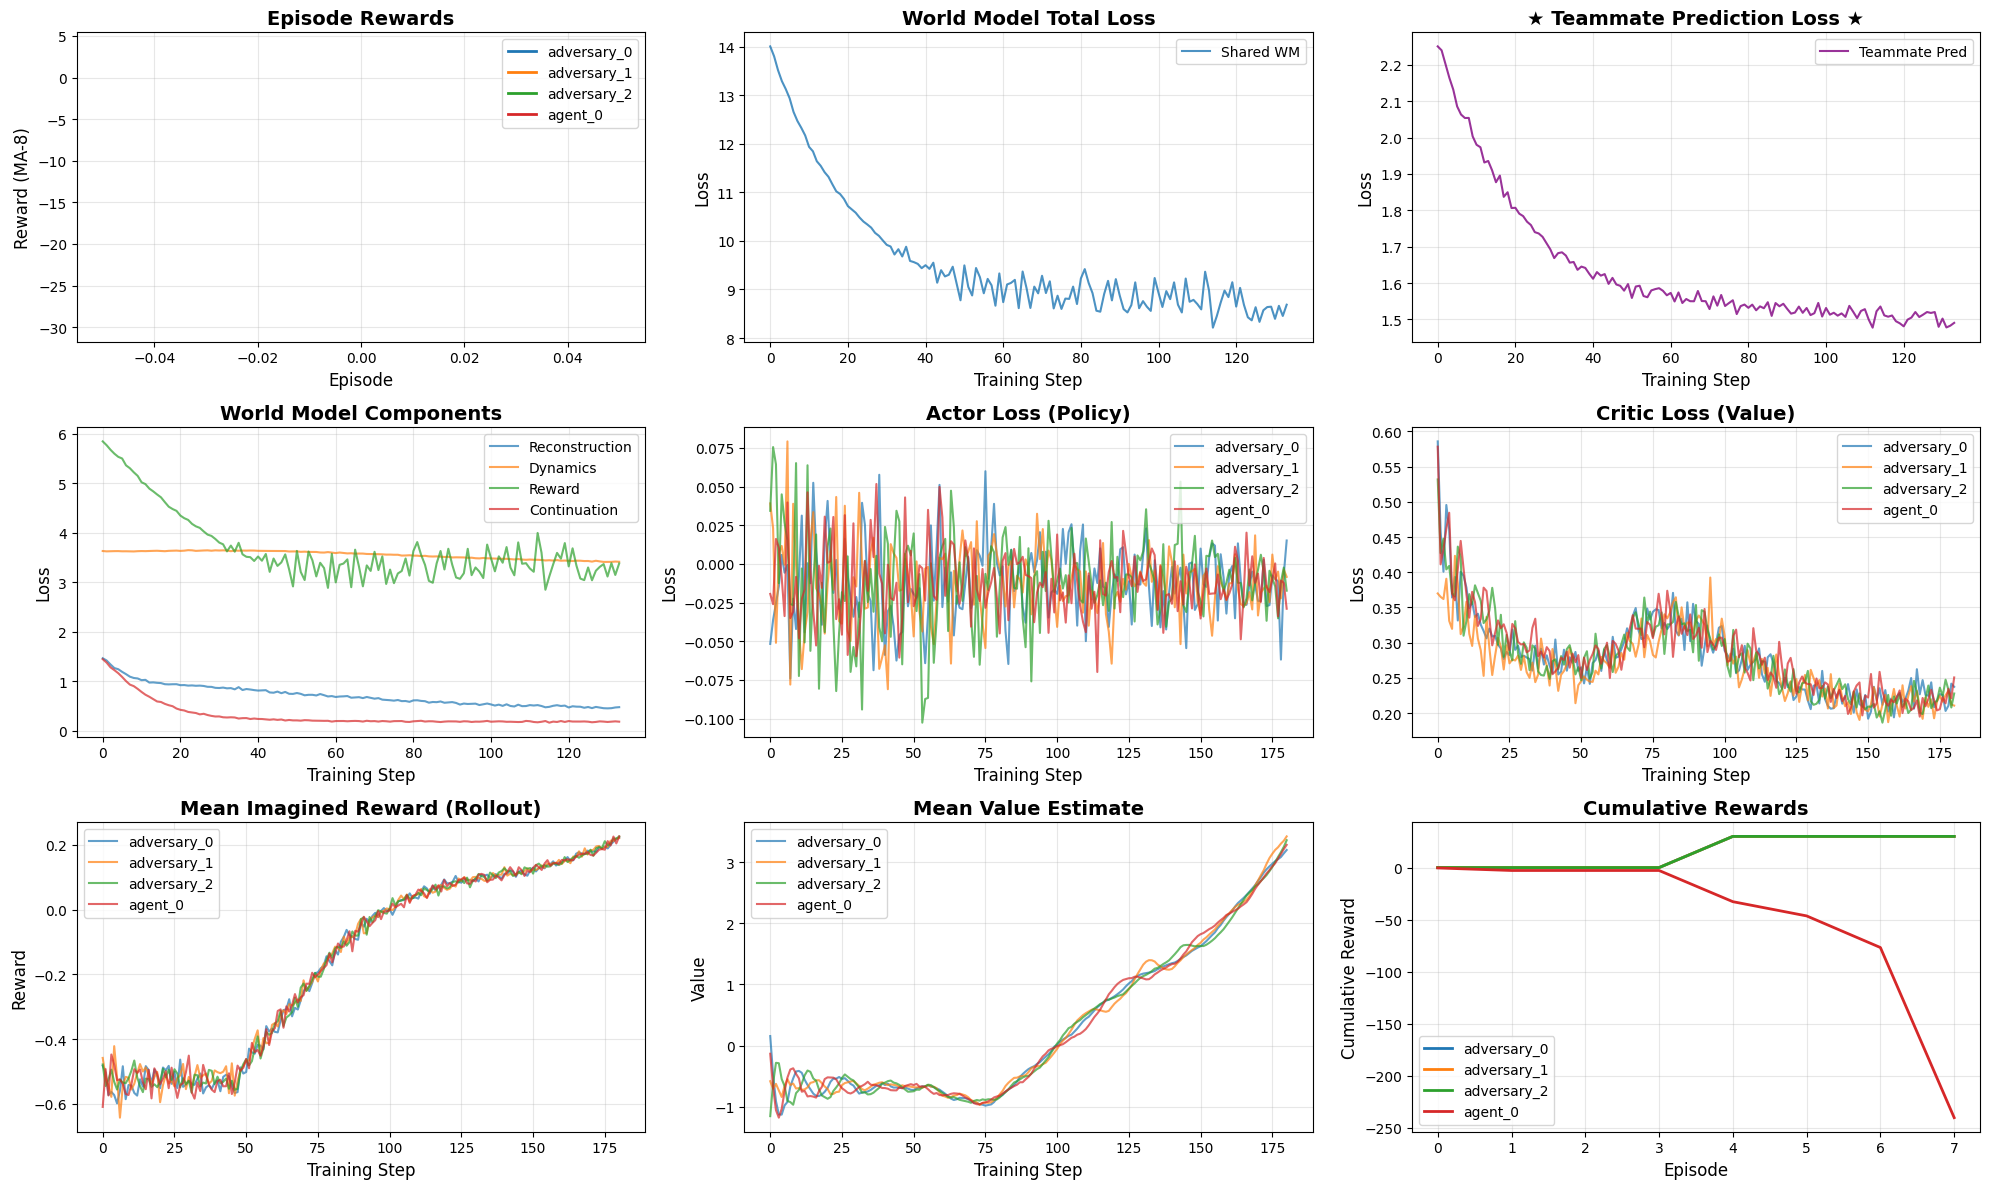

In [13]:
# 9パネル詳細可視化
print('=' * 70)
print('ENHANCED TRAINING VISUALIZATION')
print('=' * 70)
plot_training_progress(episode_rewards, training_metrics, save_path='results/training_curves_enhanced.png')

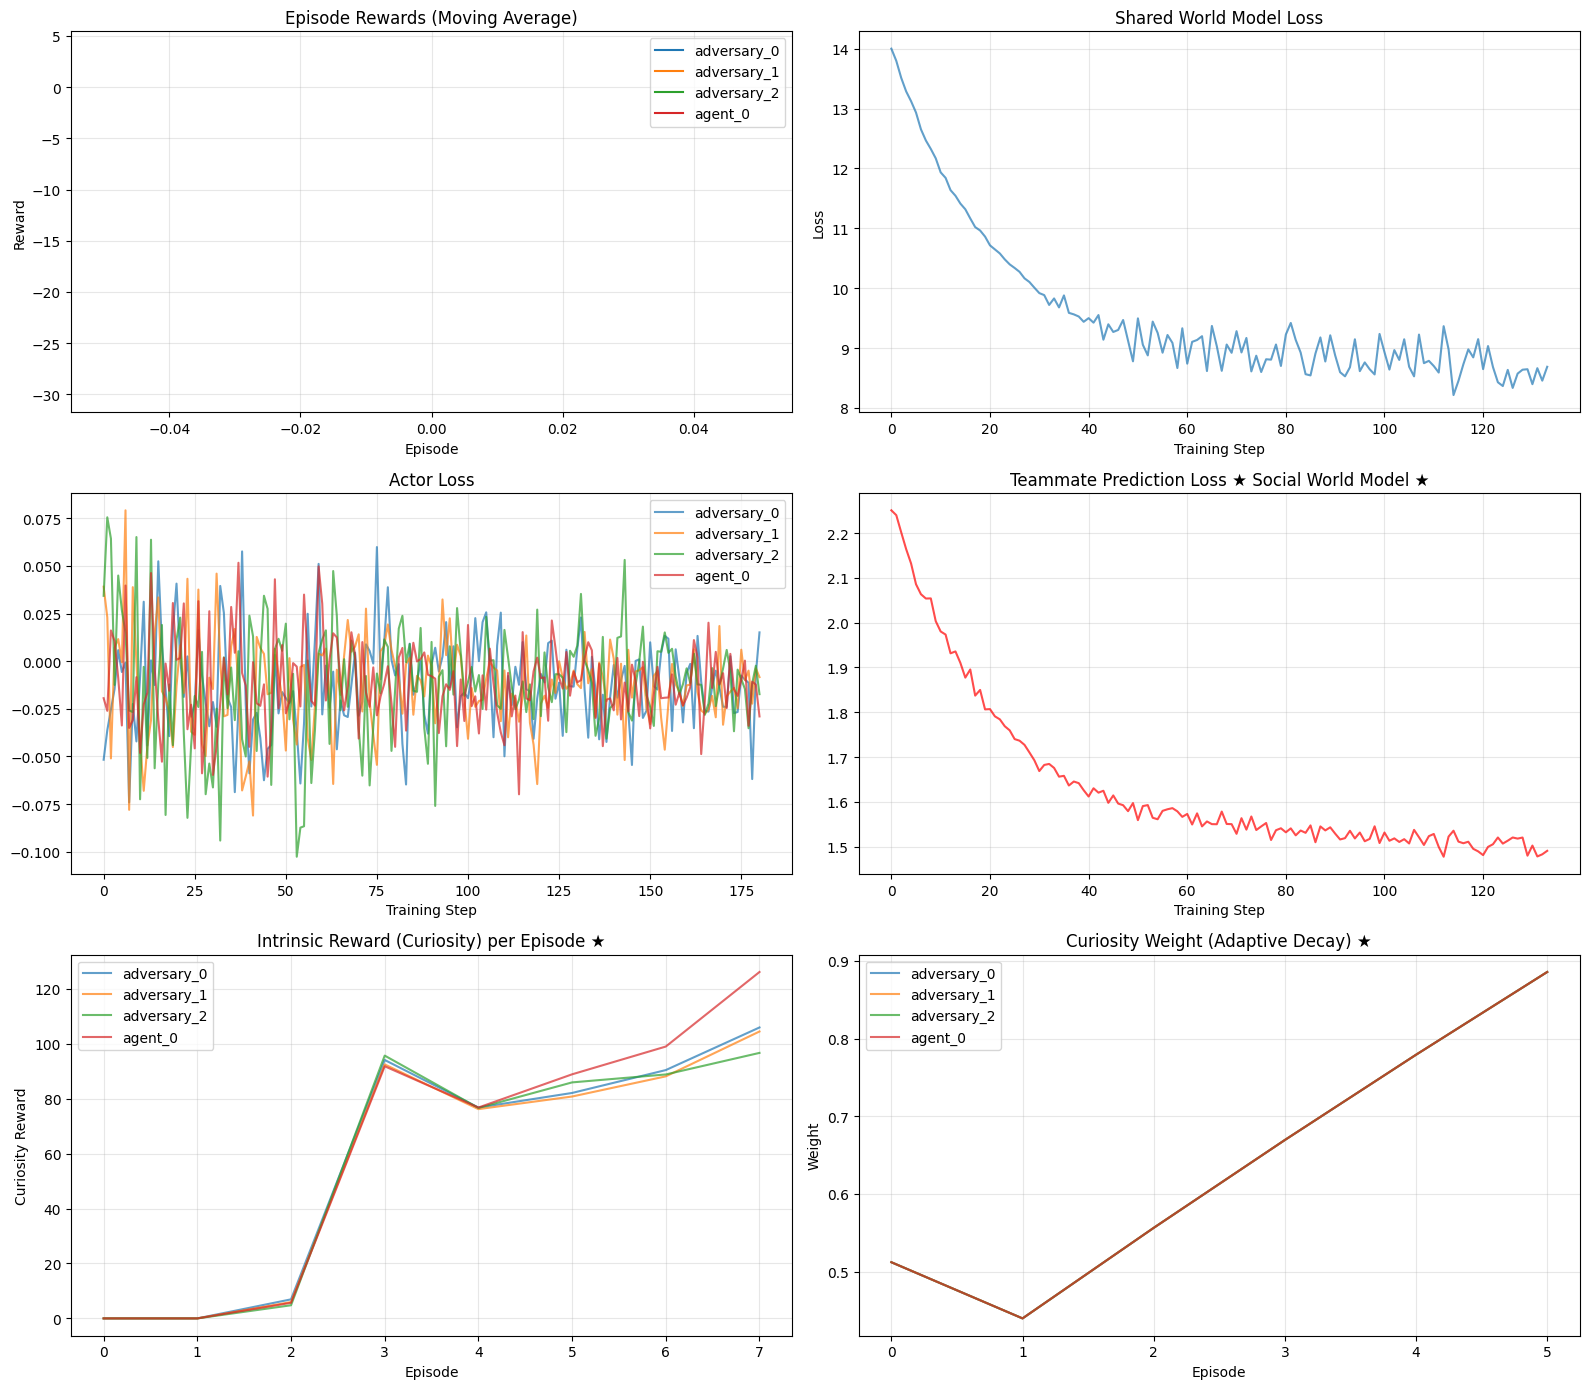

Saved to results/training_curves_curiosity.png


In [14]:
# 学習曲線 + 好奇心の推移
agent_names = list(episode_rewards.keys())

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# (0,0) Episode rewards
ax = axes[0, 0]
for name in agent_names:
    r = episode_rewards[name]
    if len(r) > 0:
        w = min(10, len(r))
        if len(r) >= w:
            ma = np.convolve(r, np.ones(w)/w, mode='valid')
            ax.plot(ma, label=name)
ax.set_title('Episode Rewards (Moving Average)')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.legend()
ax.grid(True, alpha=0.3)

# (0,1) Shared WM Total Loss
ax = axes[0, 1]
key = 'shared_wm_total_loss'
if key in training_metrics and training_metrics[key]:
    ax.plot(training_metrics[key], alpha=0.7)
ax.set_title('Shared World Model Loss')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)

# (1,0) Actor Loss
ax = axes[1, 0]
for name in agent_names:
    key = f'{name}_actor_loss'
    if key in training_metrics and training_metrics[key]:
        ax.plot(training_metrics[key], label=name, alpha=0.7)
ax.set_title('Actor Loss')
ax.set_xlabel('Training Step')
ax.legend()
ax.grid(True, alpha=0.3)

# (1,1) Teammate Prediction Loss ★
ax = axes[1, 1]
key = 'shared_wm_teammate_loss'
if key in training_metrics and training_metrics[key]:
    ax.plot(training_metrics[key], alpha=0.7, color='red')
ax.set_title('Teammate Prediction Loss ★ Social World Model ★')
ax.set_xlabel('Training Step')
ax.grid(True, alpha=0.3)

# (2,0) Curiosity Rewards per Episode ★★ 新規 ★★
ax = axes[2, 0]
for name in agent_names:
    c = episode_curiosity.get(name, [])
    if c:
        ax.plot(c, label=name, alpha=0.7)
ax.set_title('Intrinsic Reward (Curiosity) per Episode ★')
ax.set_xlabel('Episode')
ax.set_ylabel('Curiosity Reward')
ax.legend()
ax.grid(True, alpha=0.3)

# (2,1) Social Curiosity Weight の推移 ★★ 新規 ★★
ax = axes[2, 1]
for name in agent_names:
    key = f'{name}_curiosity_weight'
    if key in curiosity_metrics and curiosity_metrics[key]:
        ax.plot(curiosity_metrics[key], label=name, alpha=0.7)
ax.set_title('Curiosity Weight (Adaptive Decay) ★')
ax.set_xlabel('Episode')
ax.set_ylabel('Weight')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_curves_curiosity.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved to results/training_curves_curiosity.png')

## 8. LLM 好奇心評価ログの確認

LLM へのプロンプトと応答は `llm_logs/` ディレクトリに JSONL 形式で保存されます。

In [15]:
import json
import glob

log_files = sorted(glob.glob(os.path.join(LOG_DIR, '*.jsonl')))
print(f'LLM log files found: {len(log_files)}')

for lf in log_files:
    print(f'\n--- {os.path.basename(lf)} ---')
    with open(lf, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    print(f'  Total calls: {len(lines)}')

    # 最後の数件を表示
    for line in lines[-2:]:
        entry = json.loads(line)
        print(f'  Call #{entry["call_id"]} (ep={entry["episode"]}, {entry["latency_ms"]:.0f}ms, success={entry["success"]})')
        if entry.get('parsed_result'):
            pr = entry['parsed_result']
            print(f'    novelty={pr.get("novelty_score","?")}, social={pr.get("social_novelty","?")}')
            print(f'    phase={pr.get("exploration_phase","?")}')
            print(f'    reasoning: {pr.get("reasoning","N/A")[:120]}')

print(f'\nFull logs available at: {os.path.abspath(LOG_DIR)}/')

LLM log files found: 4

--- curiosity_adversary_0_20260208_102825.jsonl ---
  Total calls: 16
  Call #15 (ep=7, 323ms, success=False)
  Call #16 (ep=7, 313ms, success=False)

--- curiosity_adversary_1_20260208_102825.jsonl ---
  Total calls: 16
  Call #15 (ep=7, 282ms, success=False)
  Call #16 (ep=7, 300ms, success=False)

--- curiosity_adversary_2_20260208_102825.jsonl ---
  Total calls: 16
  Call #15 (ep=7, 300ms, success=False)
  Call #16 (ep=7, 413ms, success=False)

--- curiosity_agent_0_20260208_102825.jsonl ---
  Total calls: 16
  Call #15 (ep=7, 330ms, success=False)
  Call #16 (ep=7, 323ms, success=False)

Full logs available at: /content/llm_logs/


## 9. まとめと考察

### 実装した内容

本 Notebook では、MATWM に**好奇心駆動の内発的報酬**を統合した。

#### 主要コンポーネント

1. **World Model**（MATWM 論文通り）
   - Encoder/Decoder (Categorical VAE)
   - Dynamics Model (Transformer)
   - Reward/Continuation Predictor
   - **Teammate Predictor** ★ Social World Model のコア

2. **好奇心駆動の内発的報酬**（本研究の提案）
   - **Dynamics Curiosity**: 状態予測誤差 → 環境の未知領域の探索
   - **Social Curiosity ★**: チームメイト行動予測の誤差 → 協調パターンの発見
   - **LLM Semantic Curiosity**: 戦略的新規性の意味的評価

3. **適応的減衰**
   - World Model の学習進捗に連動して好奇心重みを自動調整
   - LLM による探索/活用フェーズの判断

---

### 非中央集権型MARLにおける好奇心の意義

1. **Social Curiosity は非中央集権型 MARL に固有**:
   単一エージェント RL の好奇心（RND, ICM）は環境の物理的な新規性のみを捉える。
   Social Curiosity は「他エージェントの予測外の行動」を検出し、
   社会的な不確実性の探索を促進する。

2. **信用割当の補助**:
   TeammatePredictor の予測誤差が大きい状態は、他エージェントの行動が
   環境ダイナミクスに大きな影響を与えている状態を示唆する。
   好奇心報酬により、このような状態を重点的に探索できる。

3. **探索の多様化**:
   各エージェントが異なる好奇心シグナルを持つため、
   「全員が同じ局所最適に陥る」相関探索問題が緩和される。

---

### 今後の改善案

1. **γ-Progress Curiosity**: 予測誤差の「改善度」を報酬にする（Lopes et al., 2012）
2. **Mutual Information**: エージェント間の相互情報量に基づく好奇心
3. **階層的好奇心**: 短期（ステップ単位）と長期（エピソード単位）の二重構造
4. **LLM のファインチューニング**: ドメイン特化の好奇心評価モデル